# LOADING LIBRARIES

In [3]:
import gc
import pickle
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, Dropout, Dense, SpatialDropout1D
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# LOADING DATA

In [4]:
data = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
print('Shape of data: ',data.shape)

Shape of data:  (50000, 2)


# DROP DUPLICATES

In [6]:
df = data.drop_duplicates().reset_index(drop=True)
print('Shape after dropping duplicates: ', df.shape)

Shape after dropping duplicates:  (49582, 2)


# CHECK NULL VALUES

In [7]:
df.isna().any()

review       False
sentiment    False
dtype: bool

In [8]:
df['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

# CHECK DATASET IMBALANCE

positive    24884
negative    24698
Name: sentiment, dtype: int64


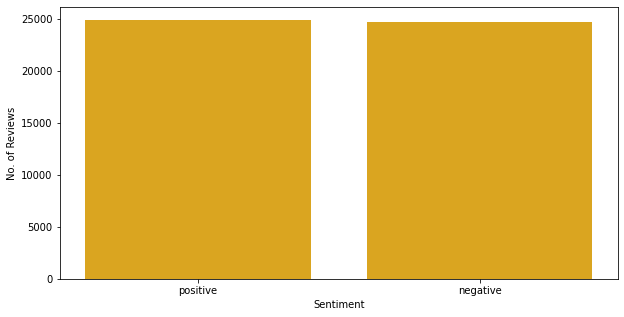

In [9]:
y = df['sentiment'].value_counts()
print(y)

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(y.index, y.values, color='goldenrod')
 
plt.xlabel("Sentiment")
plt.ylabel("No. of Reviews")
plt.show()

# DATA PREPROCESSING
***********************

* Removing unwanted words (stop_words) because they do not add any value

* Remove HTML tags

* Removing punctuations

* Removing words which has only one letter

In [10]:
stop_words = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [11]:
%%time

# remove stopwords
df['cleaned_review'] = df['review'].str.lower().apply(lambda x: ' '.join([i for i in x.split() if i not in (stop_words)]))
# remove html tags
df['cleaned_review'] = df['cleaned_review'].str.lower().str.replace('<.*?>', '', regex=True)
# remove punctuations
df['cleaned_review'] = df['cleaned_review'].str.replace('[{}]'.format(string.punctuation), ' ', regex=True)
# remove words with single letter
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: ' '.join([i for i in x.split() if len(i)>1]))

CPU times: user 20 s, sys: 89.4 ms, total: 20.1 s
Wall time: 20.2 s


In [12]:
df['cleaned_review']

0        one reviewers mentioned watching just oz episo...
1        wonderful little production the filming techni...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake thinks zombie...
4        petter mattei love time money visually stunnin...
                               ...                        
49577    thought movie right good job wasn creative ori...
49578    bad plot bad dialogue bad acting idiotic direc...
49579    catholic taught parochial elementary schools n...
49580    going disagree previous comment side maltin on...
49581    no one expects star trek movies high art fans ...
Name: cleaned_review, Length: 49582, dtype: object

# DATA PREPARATION
***********************

* Preparing label by encoding sentiment; 1 for positive and 0 for negative

* Splitting features and labels into training and test dataset in the ratio 80:20 respectively

In [13]:
label = np.array(list(map(lambda x: 1 if x=="positive" else 0, df['sentiment'])))

X_train, X_test,Y_train, Y_test = train_test_split(df['cleaned_review'], label, test_size=0.2, random_state = 42)

* Taking maximum length 150

* Creating text vocabulary and converting them into integer sequences using Keras Tokenizer

In [14]:
maxLen = 150

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
words_to_index = tokenizer.word_index

X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')

X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

* Loading GloVE Embedding file into dictionary format

* Each embedding is of length 50 and vocabulary is 95465.

* Initialising an empty matrix of shape 95465 x 50

* Fill the matrix with glove embeddings of the words

In [15]:
"""
Loading GloVE Embedding file into dictionary format
"""
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        glove_mapping = {}
        for line in f:
            word_line = line.split()
            word = word_line[0]
            glove_mapping[word] = np.array(word_line[1:], dtype=np.float64)
            
    return glove_mapping

glove_mapping = read_glove_vector('../input/glove6b50dtxt/glove.6B.50d.txt')

# Length of vocabulary
num_words = len(words_to_index) + 1
# Dimension of embedding 
embedding_dim = glove_mapping['any'].shape[0]
# Create a matrix of zeros 
embedding_matrix = np.zeros((num_words, embedding_dim))

"""
Fill the embedding matrix with glove embeddings
"""
for word, index in words_to_index.items():
    embedding_vector = glove_mapping.get(word)
    if embedding_vector is not None:
        embedding_matrix[index, :] = embedding_vector

In [16]:
num_words

95465

# INITIALIZING MODEL 
****************************

* Passing the Glove embedding matrix into the `Embedding` Layer making it trainable

* Stacking`Bi-LSTM` Layers with a `Dropout` Layer to overcome overfitting

In [17]:
model = Sequential()
model.add(Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxLen,
                    trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))
print(model.summary())

2021-11-21 08:53:39.885720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 08:53:39.994718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 08:53:39.995502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 08:53:39.996651: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           4773250   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 150, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 128)          58880     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 4,873,411
Trainable params: 4,873,411
Non-trainable params: 0
______________________________________________

* Using `Adam` as optimizer with a learning rate 0.0001

* Using `binary cross entropy` as loss function

In [18]:
adam = Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

* Using `EarlyStopping` to stop training the model if the validation loss didn't decrease for 5 epochs.

* Using `ModelCheckpoint` to save the best model with lowest validation loss.

In [19]:
callbacks = [
            EarlyStopping(monitor='val_loss', patience=5),
            ModelCheckpoint(filepath="model_epoch{epoch:02d}_loss{val_loss:03f}_acc{val_accuracy:03f}.hdf5",
                            monitor='val_loss',
                            save_best_only=True)
            ]

# TRAINING MODEL
**************

* Using `validation split` of 0.1 makes sure that we are evaluating 10% of the training dataset for evaluation at every epoch

* Training for 30 epochs

In [20]:
history = model.fit(X_train_indices, 
                    Y_train, 
                    validation_split=0.1, 
                    callbacks = callbacks,
                    epochs=30)

Epoch 1/30


2021-11-21 08:53:43.376992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-21 08:53:49.280791: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1116/1116 [==============================] - 37s 27ms/step - loss: 0.6086 - accuracy: 0.6668 - val_loss: 0.5104 - val_accuracy: 0.7625
Epoch 2/30
1116/1116 [==============================] - 28s 26ms/step - loss: 0.5279 - accuracy: 0.7441 - val_loss: 0.4581 - val_accuracy: 0.7935
Epoch 3/30
1116/1116 [==============================] - 28s 25ms/step - loss: 0.4712 - accuracy: 0.7815 - val_loss: 0.4433 - val_accuracy: 0.8112
Epoch 4/30
1116/1116 [==============================] - 29s 26ms/step - loss: 0.4339 - accuracy: 0.8039 - val_loss: 0.4170 - val_accuracy: 0.8183
Epoch 5/30
1116/1116 [==============================] - 29s 26ms/step - loss: 0.3994 - accuracy: 0.8241 - val_loss: 0.3936 - val_accuracy: 0.8286
Epoch 6/30
1116/1116 [==============================] - 29s 26ms/step - loss: 0.3718 - accuracy: 0.8371 - val_loss: 0.3818 - val_accuracy: 0.8331
Epoch 7/30
1116/1116 [==============================] - 29s 26ms/step - loss: 0.3531 - accuracy: 0.8490 - val_loss: 0.3615 - val_accura

* Model stops training after `22 epochs` due to `EarlyStopping`

* Plotting the training and validation loss and accuracy calculated while training

# PLOTTING LOSS & ACCURACY

In [21]:
def plot_graph(history,string):
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.title(string+' vs epochs')
    plt.show()

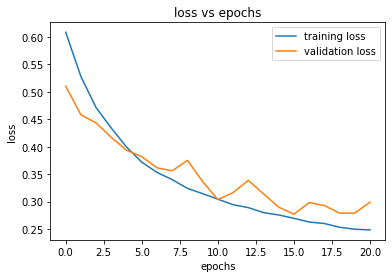

In [22]:
plot_graph(history,'loss')

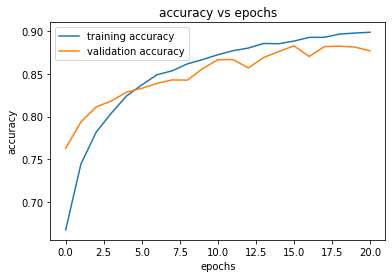

In [23]:
plot_graph(history,'accuracy')

# EVALUATING TESTING DATASET

In [24]:
X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

loss, acc = model.evaluate(X_test_indices, Y_test)
print('Testing Loss: ', loss)
print('Testing Accuracy: ', acc)

310/310 [==============================] - 3s 11ms/step - loss: 0.2945 - accuracy: 0.8789
Testing Loss:  0.29450881481170654
Testing Accuracy:  0.8788948059082031


# SAVING THE MODEL & TOKENIZER

In [25]:
"""
Save the trained model
"""
model.save(f'model_loss_{loss:0.3f}_acc_{acc:0.3f}.h5')

"""
Save the tokenizer
"""
with open('tokenizer_loss_{loss:0.3f}_acc_{acc:0.3f}.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# INFERENCE

In [26]:
"""
Function to perform preprocessing
"""
def cleaning(text):
    # remove stopwords
    text = ' '.join([i for i in text.lower().split() if i not in (stop_words)])
    # remove html tags
    text = text.replace('<.*?>', '')
    # remove punctuations
    text = text.replace('[{}]'.format(string.punctuation), ' ')
    # remove words with single letter
    text = ' '.join([i for i in text.split() if len(i)>1])
    # converting into integers
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=maxLen, padding='post')
    return text

In [27]:
text = "Such a great movie"

text = cleaning(text)
score = model.predict(text)[0][0]
print(score)
if score > 0.5:
    print("Positive")
else:
    print("Negative")

0.88371724
Positive
